In [31]:
# imports
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.calibration import calibration_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [39]:
# function to convert col names to lowercase
def clean_cols(cols):
    return [col.lower() for col in cols]

# Function to train baseline logistic regression model
def get_baseline_model_and_test_scores_for_viz(X_train, y_train, X_test, y_test):
    '''
    Running baseline logistic regression model. Returning csv with model scores that can be used
    for prelim development of heatmaps, dashboards and shooting/goaltending talent models.
    '''

    logit = LogisticRegression(max_iter=10000)
    logit.fit(X_train, y_train)

    preds_prob = pd.DataFrame(logit.predict_proba(X_test)[:, 1], columns=['preds_prob'])
    train_score = logit.score(X_train, y_train)
    test_score = logit.score(X_test, y_test)
    betas = pd.Series(logit.coef_[0], index=X_train.columns)
    betas = betas.append(pd.Series({"Intercept": logit.intercept_[0]}))

    print(betas)
    print('The train score is {} and the test score is {}'.format(train_score, test_score))
    print('The accuracy is {}'.format(accuracy_score(y_test, logit.predict(X_test))))
    print('The roc auc score is {}'.format(roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])))
    print('The log loss is {}'.format(log_loss(y_test, logit.predict_proba(X_test)[:, 1])))
    print('The precision is {}'.format(precision_score(y_test, logit.predict(X_test))))
    print('The recall is {}'.format(recall_score(y_test, logit.predict(X_test))))

    # Confusion Matrix
    y_pred = logit.predict(X_test)
    cfm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    ax = sns.heatmap(cfm, annot=True)
    ax.set(xlabel='Predicted', ylabel='Actual');
    plt.show()

    # Goal and No Goal Histograms
    y_proba = logit.predict_proba(X_test)
    y_proba = np.concatenate((y_proba.T, np.array([y_test])))
    df_proba = pd.DataFrame(y_proba.T, columns=['prob0', 'prob1', 'True'])
    sns.distplot(df_proba[df_proba['True'] == 1].prob1, bins=30, kde=False, label='Actual value 1')
    sns.distplot(df_proba[df_proba['True'] == 0].prob1, bins=30, kde=False, label='Actual value 0')
    plt.legend()
    plt.show()

# Function to build any model and test scores
def get_model_and_test_scores(mdl, X_train, y_train, X_test, y_test):
    mdl.fit(X_train, y_train)

    train_score = mdl.score(X_train, y_train)
    test_score = mdl.score(X_test, y_test)
    y_pred = mdl.predict(X_test)

    print('The train score is {} and the test score is {}'.format(train_score, test_score))
    print('The accuracy is {}'.format(accuracy_score(y_test, y_pred)))
    print('The roc auc score is {}'.format(roc_auc_score(y_test, mdl.predict_proba(X_test)[:, 1])))
    print('The log loss is {}'.format(log_loss(y_test, mdl.predict_proba(X_test)[:, 1])))
    print('The precision is {}'.format(precision_score(y_test, y_pred)))
    print('The recall is {}'.format(recall_score(y_test, y_pred)))

    # Confusion Matrix
    cfm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    ax = sns.heatmap(cfm, annot=True)
    ax.set(xlabel='Predicted', ylabel='Actual');
    plt.show()

    # Goal and No Goal Histograms
    y_proba = mdl.predict_proba(X_test)
    y_proba = np.concatenate((y_proba.T, np.array([y_test])))
    df_proba = pd.DataFrame(y_proba.T, columns=['prob0', 'prob1', 'True'])
    sns.distplot(df_proba[df_proba['True'] == 1].prob1, bins=30, kde=False, label='Actual value 1')
    sns.distplot(df_proba[df_proba['True'] == 0].prob1, bins=30, kde=False, label='Actual value 0')
    plt.legend()
    plt.show()

def grid_search_xgb(x_train, y_train):

  # A parameter grid for XGBoost
  params = {
        'min_child_weight': [1, 5, 10], #[1, 5, 10]
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5] #[3, 4, 5]
  }
  xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                      silent=True, nthread=1)

  folds = 5
  # param_comb = 5

  skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

  # random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='neg_log_loss', n_jobs=4,
  #                                    cv=skf.split(x_train, y_train), verbose=3, random_state=1001)

  grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='neg_log_loss', n_jobs=4, cv=skf.split(x_train, y_train), verbose=3)

  # print('\n Best hyperparameters:')
  # print(random_search.best_params_)

  # grid = GridSearchCV(XGBClassifier(use_label_encoder=False), param_grid, cv=5, scoring = 'neg_log_loss', error_score=0.0)
  grid_mdl = grid.fit(x_train, y_train)
  print(grid_mdl.best_score_)
  print(grid_mdl.best_params_)

  return grid


In [40]:
# Read data
file_path = "/Users/nitishkumar/pokemon_classification/datasets/Pokemon.csv"

df = pd.read_csv(file_path)
df.columns = clean_cols(df.columns)
df.head()

,pokedex no.,name,type,other type,hp,attack,defense,special attack,special defense,speed,total,generation,legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,318,1,0
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,405,1,0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,525,1,0
3,3,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,625,1,0
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,309,1,0


In [41]:
# create x and y dataframes
FEATURE_COLS = ['hp', 'attack', 'defense', 'special attack', 'special defense', 'speed']
X = df[FEATURE_COLS]
y = df['legendary']

In [43]:
# Creating random training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

hp                  0.039877
attack              0.012320
defense             0.039909
special attack      0.031702
special defense     0.019176
speed               0.046847
Intercept         -18.293279
dtype: float64
The train score is 0.93 and the test score is 0.9217391304347826
The accuracy is 0.9217391304347826
The roc auc score is 0.9213258785942492
The log loss is 0.19159471862115918
The precision is 0.5714285714285714
The recall is 0.625


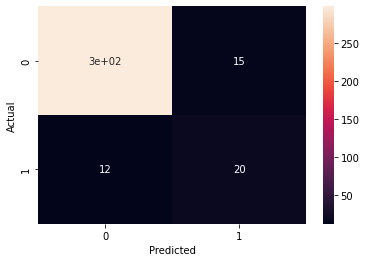

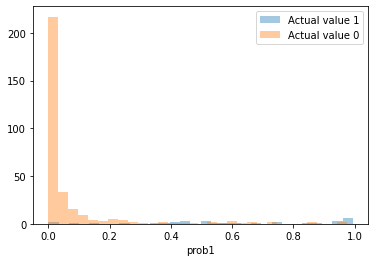

In [44]:
# Create a baseline logistic regression model
get_baseline_model_and_test_scores_for_viz(X_train, y_train, X_test, y_test)

[18:40:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:40:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The train score is 0.9657142857142857 and the test score is 0.936231884057971
The accuracy is 0.936231884057971
The roc auc score is 0.9252695686900959
The log loss is 0.19104811807527491
The precision is 0.6470588235294118
The recall is 0.6875


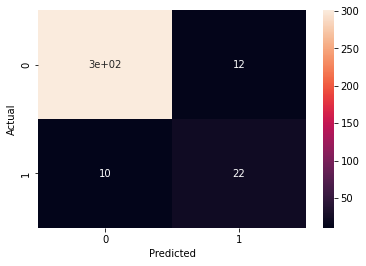

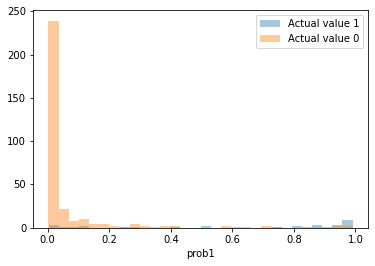

In [45]:
# Creating an xgb model

# Initiate classifier to use
mdl = XGBClassifier(learning_rate=0.02,
                   n_estimators=600,
                   min_child_weight=5,
                   max_depth=5,
                   objective='binary:logistic',
                   silent=True,
                   nthread=1)

get_model_and_test_scores(mdl, X_train, y_train, X_test, y_test)

In [ ]:
# grid search for xGB
grid_mdl = grid_search_xgb(X_train, y_train)

In [53]:
grid_mdl.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.6}

[19:07:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The train score is 0.9771428571428571 and the test score is 0.9449275362318841
The accuracy is 0.9449275362318841
The roc auc score is 0.9316094249201278
The log loss is 0.17463375801234032
The precision is 0.7096774193548387
The recall is 0.6875


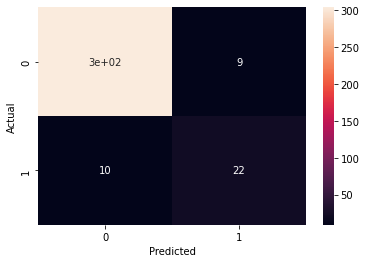

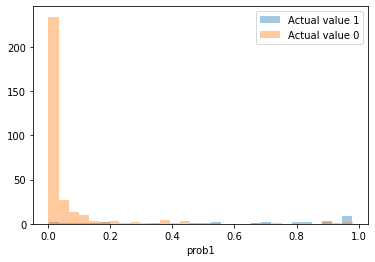

In [48]:
# Creating an xgb model

# Initiate classifier to use
mdl = XGBClassifier(learning_rate=0.02,
                   n_estimators=600,
                   min_child_weight=1,
                   max_depth=5,
                   objective='binary:logistic',
                   colsample_bytree=0.6, 
                   gamma=1.5, 
                   subsample=0.6,
                   silent=True,
                   nthread=1)

get_model_and_test_scores(mdl, X_train, y_train, X_test, y_test)

[19:07:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly h

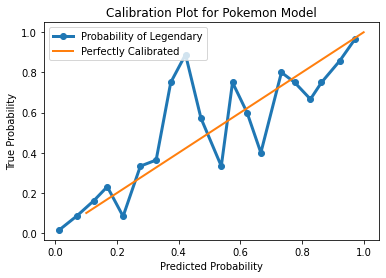

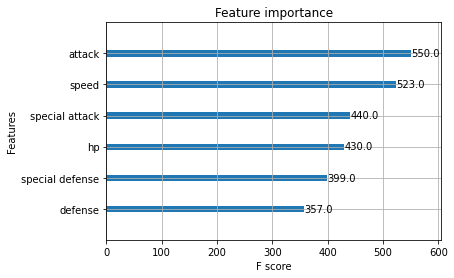

In [49]:
#### Get Calibration Curve #####
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
xg_kfold_probability = []
kfold_true_label = []

# Calculate probabilities in each k-fold
for train_index, validate_index in kf.split(df):
    kfold_train, kfold_validate = df.iloc[train_index], df.iloc[validate_index]

    train_features = kfold_train[FEATURE_COLS]
    train_labels = kfold_train['legendary']
    validate_features = kfold_validate[FEATURE_COLS]
    validate_labels = kfold_validate['legendary']

    # # Transform shot distance and angle net seen
    # columns_to_transform = ['shot_distance', 'angle_net_seen']
    # train_features = monotone_transform(train_features, columns_to_transform)
    # validate_features = monotone_transform(validate_features, columns_to_transform)

    model = mdl.fit(X=train_features, y=train_labels)
    xg_kfold_probability.append(model.predict_proba(validate_features)[:, 1])
    kfold_true_label.append(validate_labels)

xg_kfold_probability_stacked = np.hstack(xg_kfold_probability)
kfold_true_label_stacked = np.hstack(kfold_true_label)
xg_y, xg_x = calibration_curve(kfold_true_label_stacked, xg_kfold_probability_stacked, n_bins=20)

### Calibration curve plot #####
plt.plot(xg_x, xg_y, marker='o', linewidth=3, label='Probability of Legendary')
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
y = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.plot(x, y, linewidth=2, label='Perfectly Calibrated')
# Add title and axis names
plt.title('Calibration Plot for Pokemon Model')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc="upper left")
plt.show()

# plot feature importance
plot_importance(mdl)
pyplot.show()